NameError: name 'x_min' is not defined

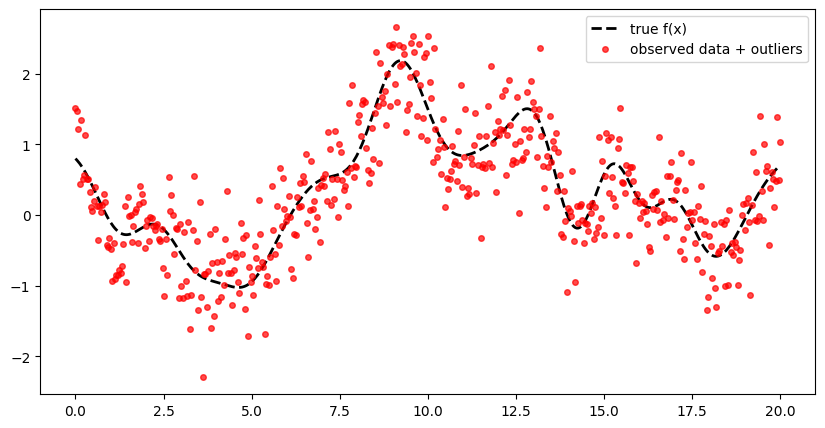

In [3]:
from typing import Optional
from zipfile import ZIP_BZIP2

import tensorflow as tf


tf.keras.backend.set_floatx('float64')
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel

from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye

import random
import numpy as np

from numpy.lib.twodim_base import histogram2d
from scipy.ndimage import variance

from tensorboard.plugins.histogram.summary import histogram
from tensorflow.python.ops.variables import trainable_variables

import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 500
sigma_n = 0.5
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

y_obs = f + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x
"""
arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

upp=2
low=1
y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

# ... [your existing imports and setup code above] ...

# After generating x_obs, y_obs:
"""
"""
# 1. Select 10 outlier positions outside the current data range:
n_outliers = 10
x_min, x_max = float(x.min()), float(x.max())
outlier_spread = 20.0  # how far beyond the range
x_outliers = np.random.uniform(
    low=x_min - outlier_spread,
    high=x_min - 0.1 * outlier_spread,
    size=(n_outliers // 2, 1)
)
x_outliers = np.vstack([
    x_outliers,
    np.random.uniform(
        low=x_max + 0.1 * outlier_spread,
        high=x_max + outlier_spread,
        size=(n_outliers - x_outliers.shape[0], 1)
    )
])

# 2. Assign y-values to outliers (e.g., sample from prior + noise):
#    You can sample from the GP prior covariance or set them arbitrarily
K_xo = kernel(x_outliers, x_outliers)
y_outliers = np.random.multivariate_normal(
    mean=np.zeros(n_outliers),
    cov=K_xo + sigma_n**2 * np.eye(n_outliers)
).reshape(-1, 1)

# 3. Append to the observed data, preserving order:
x_aug = np.vstack([x_obs, x_outliers])
y_aug = np.vstack([y_obs, y_outliers])
order = np.argsort(x_aug[:, 0])
x_obs, y_obs = x_aug[order], y_aug[order]

# Now X and y include the new outliers:
X = x  # untouched original full domain
y = y_obs  # augmented observations

# 4. Plot:
"""
plt.figure(figsize=(10, 5))
plt.plot(x, f, 'k--', lw=2, label='true f(x)')
plt.plot(x_obs, y_obs, 'r.', ms=8, alpha=0.7, label='observed data + outliers')
plt.legend()
plt.xlim(x_min - outlier_spread, x_max + outlier_spread)
plt.show()


In [3]:
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

opt = gpflow.optimizers.Scipy()
opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

f_mean, f_var = standard_gp.predict_f(x_obs, full_cov=False)

tf.reduce_mean((f_mean-f)**2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.015365752345486356>

In [3]:
standard_gp.likelihood.variance

<Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.20973218129853166>

first model, compute hyperparameters based on GVI objective for a gaussian likelihood.

In [1]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.,sigma=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.sigma=gpflow.Parameter(sigma, transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2)
        q2 = tf.matmul(eye / self.sigma**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye*self.sigma**(-2)) @ (self.y-mu_f)
        term3 = N* tf.math.log(self.sigma)
        term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(Sigma_f)
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2 + term3 + term4 + term5)
     
        return loss
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2)
        q2 = tf.matmul(eye / self.sigma**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K
    
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.001)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))

    
    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



I TRY TO UNIFY THE MODEL


In [5]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,Kernel,inducing,objective,Sigma_f_structure="c_f",lambda_method="constant",lambda_pred_lev=0.95,alpha=0.5,sigma=1.,):
        super().__init__()
        self.X = X
        self.y = y
        
        #define if we are gonna optimize through the GVI or predictive.
        self.objective = objective
        if objective == "GVI":
            self.alpha = gpflow.Parameter(alpha,trainable= False)
        else:
            self.alpha = gpflow.Parameter(alpha,trainable= True)
        
        # GP parameters
        self.kernel = Kernel
        self.inducing_variable = inducing
        self.sigma=gpflow.Parameter(sigma, transform=gpflow.utilities.positive())

        #set structure for \Sigma_f
        if Sigma_f_structure=="c_f" or Sigma_f_structure=="Inducing+c_f":
            self.c_f=gpflow.Parameter(1., transform=gpflow.utilities.positive(),trainable=True)
        self.Sigma_f_structure=Sigma_f_structure
        
        #set lambda
        if lambda_method=="constant":
            self.lambda_i=1.
        elif lambda_method=="GPC":
            self.lambda_i=tf.Variable(1.,trinable=False)
        elif lambda_method=="Calibrating":
            self.lambda_it=tf.Variable(1.,trinable=False)
            self.lambda_pred_lev=lambda_pred_lev
        elif lambda_method=="predictive":
            self.lambda_i=gpflow.Parameter(1., transform=gpflow.utilities.positive(),trainable=True)
        else:
            print("lambda method unknown")
        self.lmabda_method=lambda_method
        
    #needed for the class
    def maximum_log_likelihood_objective(self):
        pass
    
    #update Sigma_f according to method.
    @tf.function
    def compute_sigma_f(self):
        if self.Sigma_f_structure=="c_f":
            K = self.kernel(self.X, self.X)
            Sigma_f = self.c_f * K @ tf.linalg.inv(K + self.sigma**2 * eye) *self.sigma**2
        elif self.Sigma_f_structure=="Inducing+c_f":
            K = self.kernel(self.X, self.X)
            K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
            K_uf = self.kernel(self.inducing_variable, self.X)
            K_fu = tf.transpose(K_uf)
            Sigma_f =  self.c_f*tf.linalg.inv(tf.linalg.inv(K_fu@tf.linalg.inv(K_uu) @ K_uf)+eye*self.sigma**(-2))

        else:
            K = self.kernel(self.X, self.X)
            K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
            K_uf = self.kernel(self.inducing_variable, self.X)
            K_fu = tf.transpose(K_uf)
            K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())
            Sigma_f =  K_fu @ K_uu_inv @ K_uf
        return K,Sigma_f
    
    @tf.function
    def train_step(self):
        if self.objective=="GVI":
            loss=self.GVI_step()
        else:
            loss=self.Pred_step()
        if self.lambda_method == "GPC":
            self.lambda_GPC()
        if self.lambda_method == "calibrating":
            self.lambda_calibrating()
        return loss
            
    
    def GVI_step(self):
        K,Sigma_f = self.compute_sigma_f()
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        
        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2)
        q2 = tf.matmul(eye / self.sigma**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye*self.sigma**(-2)) @ (self.y-mu_f)
        term3 = N* tf.math.log(self.sigma)
        term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(Sigma_f)
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2 + term3 + term4 + term5)
     
        return loss
    
    def Pred_step(self):
        
        
    def lambda_calibrating(self):
        
        
    def sample_y(self,n_samples=100):
        N=self.X.shape[0]
        f = np.random.multivariate_normal(mean=tf.squeeze(self.mu_f) ,cov=self.Sigma_f,size=n_samples)         #put the 
        return f + np.random.normal(scale=self.sigma, size=(N,n_samples))
    
    def lambda_GPC(self):
        y_sampl=self.sample_y(n_samples)
        s=tf.reduce_mean((y_sampl-self.mu_f)**2/(tf.linalg.diag_part(self.Sigma_f)+self.sigma**2),axis=0)
        s_mean=tf.reduce_mean((self.y-self.mu_f)**2/(tf.linalg.diag_part(self.Sigma_f)+self.sigma**2),axis=0)
        return tf.reduce_mean(s<s_mean)
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2)
        q2 = tf.matmul(eye / self.sigma**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K
    
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.001)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))

    
    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



IndentationError: expected an indented block after function definition on line 112 (1409329067.py, line 115)

In [7]:

import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_MSE_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.lambda_i = gpflow.Parameter(10,transform=gpflow.utilities.positive(),trainable=False)
        #self.sigma=tf.Variable(0.3,dtype=tf.float64,trainable=False)
        self.a_p = tf.constant(1.0,dtype=tf.float64)
        self.b_p = tf.constant(1.0,dtype=tf.float64)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)

    def maximum_log_likelihood_objective(self):
        pass


    def train_step(self):

        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 =  tf.transpose(self.y-mu_f) @ (eye *self.lambda_i**2) @ (self.y-mu_f)
        term4 = self.lambda_i**2* tf.linalg.trace(Sigma_f)-N*self.lambda_i
        term3 = -tfp.distributions.Gamma(self.a_p,self.b_p).log_prob(self.lambda_i)

        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2 +term3 + term4 + term5)
        self.lambda_i.assign(N+1/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))
        return loss
        

    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K

    def update_lambda(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)

        self.lambda_i.assign(N+1/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))
        
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
            self.update_lambda()


    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



this is without term3

In [5]:

import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_MSE_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.lambda_i = gpflow.Parameter(10,transform=gpflow.utilities.positive(),trainable=False)
        #self.sigma=tf.Variable(0.3,dtype=tf.float64,trainable=False)
        self.a_p = tf.constant(10.0,dtype=tf.float64)
        self.b_p = tf.constant(10.0,dtype=tf.float64)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)

    def maximum_log_likelihood_objective(self):
        pass


    def train_step(self):

        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 =  tf.transpose(self.y-mu_f) @ (eye *self.lambda_i**2) @ (self.y-mu_f)
        term4 = self.lambda_i**2* tf.linalg.trace(Sigma_f)-N*self.lambda_i
        

        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2  + term4 + term5)
        self.lambda_i.assign(N+1/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))
        return loss
        

    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K

    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
            



    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [6]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split

class GVI_GP_lambdaGPC_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.,sigma=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= True)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.sigma=gpflow.Parameter(sigma,transform=gpflow.utilities.positive())
        self.lambda_vec=tf.constant([0.1,0.3,0.5,0.7,0.8,0.9,1.,1.1,1.3,1.5,2.],dtype=tf.float64)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self,test_size=0.1):
        np.random.seed(1)
        X_train,X_test, y_train, y_test =train_test_split(self.X, self.y, test_size=test_size)
        K = self.kernel(X_train, X_train)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X_train)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())


        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        K_inv=tf.linalg.inv(K+jitter)
        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.sigma**2*self.lambda_it)
        q2 = tf.matmul(eye *self.sigma**2*self.lambda_it,y_train)
        mu_f= tf.matmul(q1, q2)
        
        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye*self.sigma**(-2)) @ (self.y-mu_f)
        term3 = N* tf.math.log(self.sigma)
        term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(Sigma_f)
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2 + term3 + term4 + term5)

        return loss
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye / self.sigma**2*self.lambda_it)
        q2 = tf.matmul(eye / self.sigma**2*self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K
    
    def sample_y(self,n_samples=100):
        N=self.X.shape[0]
        f = np.random.multivariate_normal(mean=tf.squeeze(self.mu_f) ,cov=self.Sigma_f,size=n_samples)         #put the 
        return f + np.random.normal(scale=self.sigma.numpy(), size=(n_samples,N))
    
    def compute_lambda_stat(self,n_samples=100):
        y_sampl=self.sample_y(n_samples)
        s = tf.reduce_mean(
                (y_sampl - tf.reshape(self.mu_f, [1, -1]))**2 / 
                    (tf.linalg.diag_part(self.Sigma_f) + self.sigma**2),    axis=0)    
    
        s_mean=tf.reduce_mean((self.y-self.mu_f)**2/(tf.linalg.diag_part(self.Sigma_f)+self.sigma**2),axis=0)
        return tf.reduce_mean(tf.cast(s < s_mean, tf.float32))
        
    def internal_opt(self):

        test_values=[]
        for lambda_it in self.lambda_vec:
            self.lambda_it=lambda_it
            opt = gpflow.optimizers.Scipy()
            opt.minimize(model.train_step, model.trainable_variables)
            self.predict_ins()
            test_values.append(self.compute_lambda_stat())
        ##choose lambda with best 
        self.lambda_it=self.lambda_vec[test_values.index(min(test_values))]
        ##fit model with that lambda
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model.train_step, model.trainable_variables)
        
    
    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [57]:
         
import time
from sklearn.model_selection import train_test_split
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_lambdaGPC_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=1.)
        self.sigma=gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.inducing_variable = inducing


        self.X_train,self.X_test, self.y_train,self.y_test =train_test_split(self.X, self.y,test_size=0.2)
    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    def sample_y(self,n_samples=100):
        N=self.X.shape[0]
        f = np.random.multivariate_normal(mean=tf.squeeze(self.mu_f) ,cov=self.Sigma_f,size=n_samples)         #put the 
        return f + np.random.normal(scale=self.sigma.numpy(), size=(n_samples,N))

    def compute_lambda_stat(self,n_samples=100):
        y_sampl=self.sample_y(n_samples)
        s = tf.reduce_mean(
                (y_sampl - tf.reshape(self.mu_f, [1, -1]))**2 / 
                    (tf.linalg.diag_part(self.Sigma_f) + self.sigma**2),    axis=0)    
    
        s_mean=tf.reduce_mean((self.y-self.mu_f)**2/(tf.linalg.diag_part(self.Sigma_f)+self.sigma**2),axis=0)
        return tf.reduce_mean(tf.cast(s < s_mean, tf.float32))


    def train_step(self):

        K = self.kernel(self.X_train, self.X_train)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X_train)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())


        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        K_inv=tf.linalg.inv(K+jitter)
        Sigma_f_inv=tf.linalg.inv(Sigma_f+jitter)
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it*self.sigma**2)
        q2 = tf.matmul(eye *self.lambda_it*self.sigma**2,self.y_train)
        mu_f= tf.matmul(q1, q2)
        
        K_star=self.kernel(self.X_test, self.X_train)
        K_star_star=self.kernel(self.X_test, self.X_test)

        var_pred=tf.linalg.diag_part(K_star_star+K_star@K_inv@Sigma_f@tf.transpose(K_star@K_inv))+self.sigma**2

        loss1=tf.reduce_mean(0.5*(self.y_test-K_star@Sigma_f_inv@mu_f)**2/var_pred+0.5*tf.math.log(var_pred))
        
        return loss1
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.lambda_it)
        q2 = tf.matmul(eye*self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
    
    def predict_out(self,X):
        K = self.kernel(self.X, self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K)[0], dtype=K.dtype)
        K_inv = tf.linalg.inv(K + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f
    
def internal_opt():

    test_values=[]
    lambda_vec=tf.constant([0.1,0.3,0.5,0.7,0.8,0.9,1.,1.1,1.3,1.5,2.,10.,50.],dtype=tf.float64)
    for lambda_it in lambda_vec:
        model = GVI_GP_lambdaGPC_alpha(x_obs,y_obs,inducing_variable)
        model.lambda_it=lambda_it
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model.train_step, model.trainable_variables)
        model.predict_ins()
        test_values.append(model.compute_lambda_stat())
        ##choose lambda with best
    model = GVI_GP_lambdaGPC_alpha(x_obs,y_obs,inducing_variable)
    model.lambda_it=lambda_vec[test_values.index(min(test_values))]
        ##fit model with that lambda
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.train_step, model.trainable_variables)
    return model



In [58]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model=internal_opt()


Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
Tensor("Cast:0", shape=(), dtype=float64)


AttributeError: 'GVI_GP_lambdaGPC_alpha' object has no attribute 'mu_f'

In [59]:
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=0.09094854192179852>

<tf.Tensor: shape=(), dtype=float64, numpy=0.5>

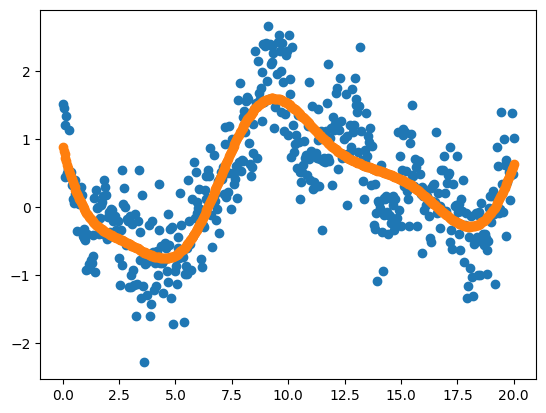

In [61]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,tf.squeeze(model.mu_f))

In [42]:
model.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=6.896005942233122e-07>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-6.100923801205797>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=2.06407254044255>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-2.1509579143248674>)

In [106]:
model.sigma

<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=2.500306082580392>

In [17]:
model.compute_lambda_stat()

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [7]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_alpha(x_obs,y_obs,inducing_variable)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<dtype: 'float64'>
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=1.2818892070827483>

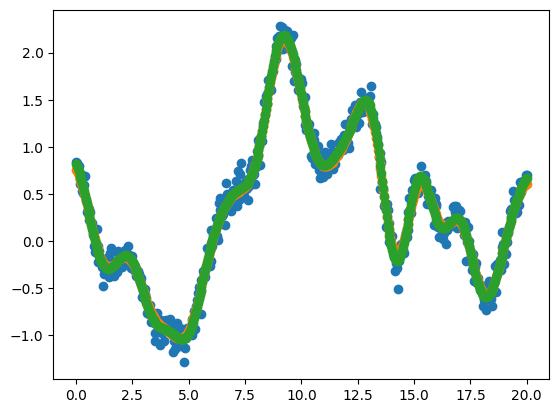

In [8]:
plt.scatter(x_obs,y_obs)
#plt.scatter(x_obs,model.mu_f)
plt.scatter(x_obs,tf.squeeze(model.mu_f))
plt.scatter(x_obs,f_mean)
#plt.scatter(x_obs, f)


In [9]:
tf.reduce_mean(abs(model.mu_f - f))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9087355970292811>

In [10]:
tf.reduce_mean(abs(f_mean - f))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9149153216953898>

this is with GVI OBJECTIVE, and lambda estimated based on moments. TO CHANGE

In [11]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_lambda_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=[1.])
        self.inducing_variable = inducing
        self.lambda_it=gpflow.Parameter(1., transform=gpflow.utilities.positive(),trainable=False)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it)
        q2 = tf.matmul(eye *self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye *self.lambda_it) @ (self.y-mu_f)
        term4 = 0.5 * self.lambda_it * tf.linalg.trace(Sigma_f)
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2  + term4 + term5)
        
        self.lambda_it.assign(tf.reduce_mean((self.y-mu_f)**2+tf.linalg.diag_part(Sigma_f))/self.alpha)
        return loss
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.lambda_it)
        q2 = tf.matmul(eye*self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
    
    def predict_out(self,X):
        K = self.kernel(self.X, self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K)[0], dtype=K.dtype)
        K_inv = tf.linalg.inv(K + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [12]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_alpha(x_obs,y_obs,inducing_variable)
model.internal_opt(300)
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<dtype: 'float64'>
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=1.2758177239499204>

THIS IS THE ONE BASED ON PREDICTIVE


In [84]:
         
import time
from sklearn.model_selection import train_test_split
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_lambda_pred_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=1.)
        self.inducing_variable = inducing
        self.lambda_it=gpflow.Parameter(1., transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def Pred_step(self,test_size=0.1):
        X_train,X_test, y_train, y_test =train_test_split(self.X, self.y, test_size=test_size)
        K = self.kernel(X_train, X_train)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X_train)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())


        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        K_inv=tf.linalg.inv(K+jitter)
        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it)
        q2 = tf.matmul(eye *self.lambda_it,y_train)
        mu_f= tf.matmul(q1, q2)
        
        K_star=self.kernel(X_test, X_train)
        K_star_star=self.kernel(X_test, X_test)

        loss1=tf.reduce_mean((y_test-K_star@K_inv@mu_f)**2+tf.linalg.diag_part(K_star_star-K_star@K_inv@tf.transpose(K_star)+K_star@K_inv@Sigma_f@tf.transpose(K_star@K_inv)))
        return loss1
        
    @tf.function
    def GVI_step(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())


        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it)
        q2 = tf.matmul(eye *self.lambda_it,self.y)
        mu_f= tf.matmul(q1, q2)
        
        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye *self.lambda_it) @ (self.y-mu_f)
        term4 = 0.5 * self.lambda_it * tf.linalg.trace(Sigma_f)
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss2 = tf.squeeze(term1 +term2  + term4 + term5)
        return loss2
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.lambda_it)
        q2 = tf.matmul(eye*self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
    
    def predict_out(self,X):
        K = self.kernel(self.X, self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K)[0], dtype=K.dtype)
        K_inv = tf.linalg.inv(K + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f
    
    def internal_opt(self,n_it=100):
        optimizer1 = tf.optimizers.Adam(learning_rate=0.001)
        optimizer2 = tf.optimizers.Adam(learning_rate=0.001)
        inducing_var = self.inducing_variable
        other_vars = [v for v in self.trainable_variables if v is not inducing_var]
        inducing_tfvar = self.inducing_variable.unconstrained_variable
        # Get trainable variables excluding inducing variables
        for i in range(n_it):
            with tf.GradientTape() as tape:
                tape.watch(self.inducing_variable)
                loss1 = self.GVI_step()

            grads = tape.gradient(loss1, inducing_tfvar)
            optimizer1.apply_gradients([(grads, inducing_tfvar)])
            with tf.GradientTape() as tape:
                loss = self.Pred_step()
            grads = tape.gradient(loss, other_vars)
            optimizer2.apply_gradients(zip(grads,other_vars))



In [27]:
         
import time
from sklearn.model_selection import train_test_split
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_lambda_interval_pred_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=1.)
        self.inducing_variable = inducing
        self.lambda_it=tf.Variable(.5,trainable=False,dtype=tf.float64)
        self.v1_track=[]

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def Pred_step(self,test_size=0.1):
        X_train,X_test, y_train, y_test =train_test_split(self.X, self.y, test_size=test_size)
        K = self.kernel(X_train, X_train)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X_train)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())


        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        K_inv=tf.linalg.inv(K+jitter)
        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it)
        q2 = tf.matmul(eye *self.lambda_it,y_train)
        mu_f= tf.matmul(q1, q2)
        
        K_star=self.kernel(X_test, X_train)
        K_star_star=self.kernel(X_test, X_test)
        
        pred_mean=K_star@K_inv@mu_f
        pred_var=tf.linalg.diag_part(K_star_star-K_star@K_inv@tf.transpose(K_star)+K_star@K_inv@Sigma_f@tf.transpose(K_star@K_inv))
        quant=[0.05,0.1,0.3,0.5,0.7,0.9,0.95]#convert it to 
        quant_norm=[-1.96,-1.72,-1.1,0,1.1,1.72,1.96]
        v1=0
        for i in range(len(quant)):
            v1 += tf.reduce_mean(tf.cast(y_test < pred_mean + quant_norm[i] * pred_var, tf.float64)) - quant[i]
        self.lambda_it.assign(self.lambda_it+0.05*v1)
        clamped_lambda = tf.clip_by_value(self.lambda_it, 0.0, 1.0)
        self.lambda_it.assign(clamped_lambda)
            
        loss=tf.reduce_mean(tf.square(y_test-pred_mean)/pred_var)
        return loss
    @tf.function
    def GVI_step(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())


        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it)
        q2 = tf.matmul(eye *self.lambda_it,self.y)
        mu_f= tf.matmul(q1, q2)
        
        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)

        # Loss terms
        term1 = 0.5 * tf.transpose(self.y-mu_f) @ (eye *self.lambda_it) @ (self.y-mu_f)
        term4 = 0.5 * self.lambda_it * tf.linalg.trace(Sigma_f)
        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss2 = tf.squeeze(term1 +term2  + term4 + term5)
        return loss2
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.lambda_it)
        q2 = tf.matmul(eye*self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
    
    def predict_out(self,X):
        K = self.kernel(self.X, self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K)[0], dtype=K.dtype)
        K_inv = tf.linalg.inv(K + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f
    
    def internal_opt(self,n_it=100):
        optimizer1 = tf.optimizers.Adam(learning_rate=0.001)
        optimizer2 = tf.optimizers.Adam(learning_rate=0.001)
        inducing_var = self.inducing_variable
        other_vars = [v for v in self.trainable_variables if v is not inducing_var]
        inducing_tfvar = self.inducing_variable.unconstrained_variable
        # Get trainable variables excluding inducing variables
        for i in range(n_it):
            with tf.GradientTape() as tape:
                tape.watch(self.inducing_variable)
                loss1 = self.GVI_step()

            grads = tape.gradient(loss1, inducing_tfvar)
            optimizer1.apply_gradients([(grads, inducing_tfvar)])
            with tf.GradientTape() as tape:
                loss = self.Pred_step()
            grads = tape.gradient(loss, other_vars)
            optimizer2.apply_gradients(zip(grads,other_vars))



In [28]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_lambda_interval_pred_alpha(x_obs,y_obs,inducing_variable)
model.internal_opt(300)
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

Tensor("Cast:0", shape=(), dtype=float64)
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=1.2878917410486168>

In [29]:
model.lambda_it

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>

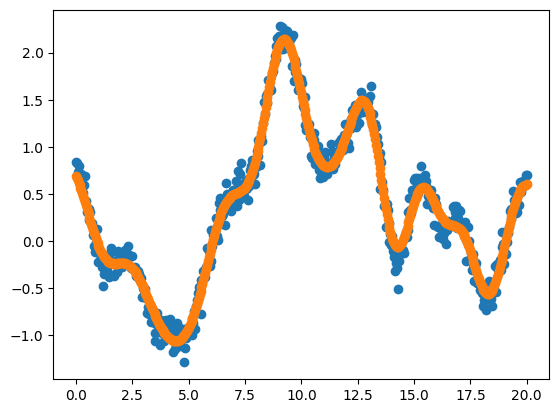

In [31]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.mu_f)

In [85]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_lambda_pred_alpha(x_obs,y_obs,inducing_variable)
model.internal_opt(300)
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

Tensor("Cast:0", shape=(), dtype=float64)
Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=1.292355624958334>

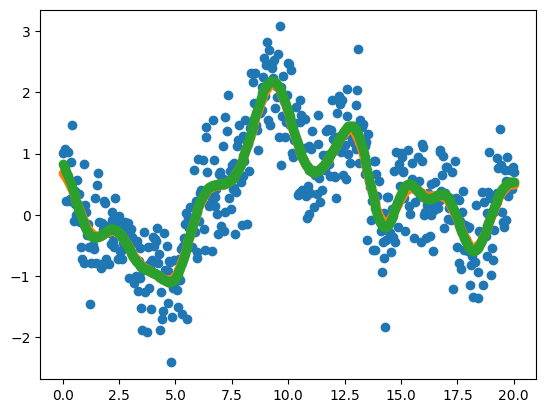

In [87]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.mu_f)
plt.scatter(x_obs,f_mean)

THIS IS PREDICTIVE WITHOUT INDUCING POINTS



In [91]:
         
import time
from sklearn.model_selection import train_test_split
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_lambda_pred_NOIND_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=1.)
        self.inducing_variable = inducing
        self.lambda_it=gpflow.Parameter(1., transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self,test_size=0.1):
        X_train,X_test, y_train, y_test =train_test_split(self.X, self.y, test_size=test_size)
        K = self.kernel(X_train, X_train)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X_train)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())


        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        K_inv=tf.linalg.inv(K+jitter)
        Sigma_f_inv=tf.linalg.inv(Sigma_f+jitter)
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it)
        q2 = tf.matmul(eye *self.lambda_it,y_train)
        mu_f= tf.matmul(q1, q2)
        
        K_star=self.kernel(X_test, X_train)
        K_star_star=self.kernel(X_test, X_test)

        loss1=tf.reduce_mean((y_test-K_star@Sigma_f_inv@mu_f)**2+tf.linalg.diag_part(K_star_star+K_star@K_inv@Sigma_f@tf.transpose(K_star@K_inv)))
        
        return loss1
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.lambda_it)
        q2 = tf.matmul(eye*self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
    
    def predict_out(self,X):
        K = self.kernel(self.X, self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K)[0], dtype=K.dtype)
        K_inv = tf.linalg.inv(K + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f
    
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.001)
        #kernel_vars = self.kernel.trainable_variables
        other_vars = [self.alpha, self.lambda_it]
        # Get trainable variables excluding inducing variables
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss1 = self.train_step()
            grads = tape.gradient(loss1, self.trainable_variables)
            optimizer.apply_gradients(zip(grads,self.trainable_variables))



In [34]:
         
import time
from sklearn.model_selection import train_test_split
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_lambda_interval_NOIND_pred_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=1.)
        self.inducing_variable = inducing
        self.lambda_it=tf.Variable(.5,trainable=False,dtype=tf.float64)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self,test_size=0.1):
        X_train,X_test, y_train, y_test =train_test_split(self.X, self.y, test_size=test_size)
        K = self.kernel(X_train, X_train)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X_train)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())


        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        K_inv=tf.linalg.inv(K+jitter)
        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it)
        q2 = tf.matmul(eye *self.lambda_it,y_train)
        mu_f= tf.matmul(q1, q2)
        
        K_star=self.kernel(X_test, X_train)
        K_star_star=self.kernel(X_test, X_test)
        
        pred_mean=K_star@K_inv@mu_f
        pred_var=tf.linalg.diag_part(K_star_star-K_star@K_inv@tf.transpose(K_star)+K_star@K_inv@Sigma_f@tf.transpose(K_star@K_inv))
        quant=[0.05,0.1,0.3,0.5,0.7,0.9,0.95]#convert it to 
        quant_norm=[-1.96,-1.72,-1.1,0,1.1,1.72,1.96]
        v1=0
        for i in range(len(quant)):
            v1 += tf.reduce_mean(tf.cast(y_test < pred_mean + quant_norm[i] * pred_var, tf.float64)) - quant[i]
        self.lambda_it.assign(self.lambda_it+0.05*v1)
        clamped_lambda = tf.clip_by_value(self.lambda_it, 0.0, 1.0)
        self.lambda_it.assign(clamped_lambda)
            
        loss=tf.reduce_mean(tf.square(y_test-pred_mean)/pred_var)
        return loss
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)
        
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.lambda_it)
        q2 = tf.matmul(eye*self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
    
    def predict_out(self,X):
        K = self.kernel(self.X, self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K)[0], dtype=K.dtype)
        K_inv = tf.linalg.inv(K + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f
    
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.001)
        #kernel_vars = self.kernel.trainable_variables
        # Get trainable variables excluding inducing variables
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss1 = self.train_step()
            grads = tape.gradient(loss1, self.trainable_variables)
            optimizer.apply_gradients(zip(grads,self.trainable_variables))




In [93]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model=GVI_GP_lambda_pred_NOIND_alpha(x_obs,y_obs,inducing_variable)

model.internal_opt(300)
model.predict_ins()

tf.reduce_mean((model.mu_f - f) ** 2)

Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=1.2945927277651905>

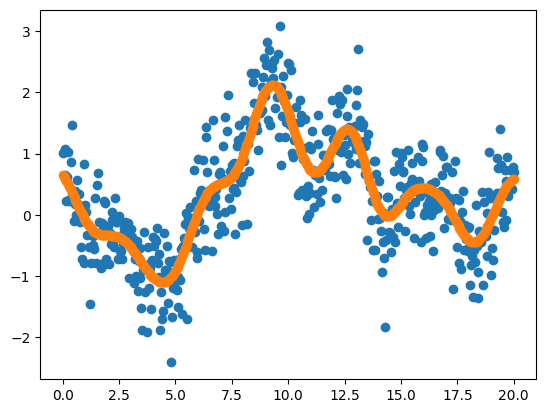

In [94]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.mu_f)

In [41]:
model.lambda_it

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.07446000000000177>

In [16]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 20, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_lambda_pred_NOIND_alpha(x_obs,y_obs,inducing_variable)
model.internal_opt(300)
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=1.2675023832489287>

In [19]:
         
import time
from sklearn.model_selection import train_test_split
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_lambda_2K_pred_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=1.)
        self.kernel_q = gpflow.kernels.SquaredExponential(lengthscales=1.)
        self.lambda_it=gpflow.Parameter(1., transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self,test_size=0.1):
        X_train,X_test, y_train, y_test =train_test_split(self.X, self.y, test_size=test_size)
        K = self.kernel(X_train, X_train)
        Sigma_f =self.kernel_q(X_train, X_train)
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        K_inv=tf.linalg.inv(K+jitter)
        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye * self.lambda_it)
        q2 = tf.matmul(eye *self.lambda_it,y_train)
        mu_f= tf.matmul(q1, q2)
        
        K_star=self.kernel(X_test, X_train)
        K_star_star=self.kernel(X_test, X_test)

        loss1=tf.reduce_mean((y_test-K_star@K_inv@mu_f)**2+tf.linalg.diag_part(K_star_star+K_star@K_inv@Sigma_f@tf.transpose(K_star@K_inv)))
        
        return loss1
    
    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        
        Sigma_f = self.kernel_q(self.X, self.X)
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6

        
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *self.lambda_it)
        q2 = tf.matmul(eye*self.lambda_it, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
    
    def predict_out(self,X):
        K = self.kernel(self.X, self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K)[0], dtype=K.dtype)
        K_inv = tf.linalg.inv(K + jitter)
        
        return K_xold_xnew @ K_inv @ self.mu_f
    
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.001)
        #kernel_vars = self.kernel.trainable_variables
        other_vars = [self.alpha, self.lambda_it]
        # Get trainable variables excluding inducing variables
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss1 = self.train_step()
            grads = tape.gradient(loss1, self.trainable_variables)
            optimizer.apply_gradients(zip(grads,self.trainable_variables))



In [18]:
model = GVI_GP_lambda_2K_pred_alpha(x_obs,y_obs)
model.internal_opt(300)
model.predict_ins()
tf.reduce_mean(abs(model.mu_f - f))

Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>


<tf.Tensor: shape=(), dtype=float64, numpy=0.9152897336571868>

In [20]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SGPR_2k_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, inducing, N_u, alpha=0.5):
        super().__init__()
        self.X = X  # [N, D]
        self.y = y  # [N, 1]
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.variance_q = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale_q = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.variance = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.sigma = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    

    def train_step(self):
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)


        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        kernel_q = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance_q, self.lengthscale_q)
        Sigma_u = kernel_q.matrix(self.inducing_variable, self.inducing_variable)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
        mu_u = tf.matmul(q1, q2)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual = self.y - K_fu@K_uu_inv @ mu_u
        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma**-2)
        term2 = 0.5 * self.alpha * tf.reduce_sum(mu_u *(Sigma_a_inv @ mu_u))
        term3 = N * tf.math.log(self.sigma)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 * (self.sigma**-2) * (tf.reduce_sum(kernel.apply(self.X, self.X)) - tf.linalg.trace(T1) +tf.linalg.trace(T2))
        term5 = -1.0/(2.0*(self.alpha-1.0)) * (ld_Sig_a + (self.alpha-1.0)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2 + term3 +term4 + term5
        return tf.squeeze(loss)

    def predict_ins(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        kernel_q = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance_q, self.lengthscale_q)
        Sigma_u = kernel_q.matrix(self.inducing_variable, self.inducing_variable)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
        mu_u = tf.matmul(q1, q2)

        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        
        kernel_q = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance_q, self.lengthscale_q)
        K_uu_inv = self.stable_solve(K_uu, I_M)
        Sigma=tf.linalg.diag_part(kernel.matrix(Xnew,Xnew)-K_xu@K_uu_inv@tf.transpose(K_xu)+K_xu@K_uu_inv@self.Sigma_u@K_uu_inv@tf.transpose(K_xu))


        return K_xu@K_uu_inv@self.mu_u
    def maximum_log_likelihood_objective(self):
        pass
# === Usage ===





In [21]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 100, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_SGPR_2k_alpha(x_obs, y_obs, inducing_variable, 100)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
preds = model.predict_out(x_obs)

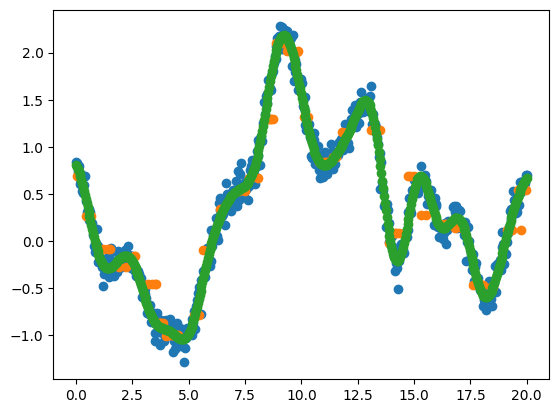

In [22]:
plt.scatter(x_obs,y_obs)
plt.scatter(Z,model.mu_u)
plt.scatter(x_obs,preds)

In [18]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SGPR_diag_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, inducing, N_u, alpha=0.5):
        super().__init__()
        self.X = X  # [N, D]
        self.y = y  # [N, 1]
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.Var_q= gpflow.Parameter([1.]*N_u, transform=gpflow.utilities.positive())
        self.variance = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.sigma = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    

    def train_step(self):
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)


        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = tf.linalg.diag(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
        mu_u = tf.matmul(q1, q2)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual = self.y - K_fu@K_uu_inv @ mu_u
        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma**-2)
        term2 = 0.5 * self.alpha * tf.reduce_sum(mu_u *(Sigma_a_inv @ mu_u))
        term3 = N * tf.math.log(self.sigma)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 * (self.sigma**-2) * (tf.reduce_sum(kernel.apply(self.X, self.X)) - tf.linalg.trace(T1) +tf.linalg.trace(T2))
        term5 = -1.0/(2.0*(self.alpha-1.0)) * (ld_Sig_a + (self.alpha-1.0)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2 + term3 +term4 + term5
        return tf.squeeze(loss)

    def predict_ins(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = tf.linalg.diag(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)

        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        
        K_uu_inv = self.stable_solve(K_uu, I_M)


        return K_xu@K_uu_inv@self.mu_u
    def maximum_log_likelihood_objective(self):
        pass
# === Usage ===





In [26]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 100, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_SGPR_diag_alpha(x_obs, y_obs, inducing_variable, 100)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
preds = model.predict_out(x_obs)

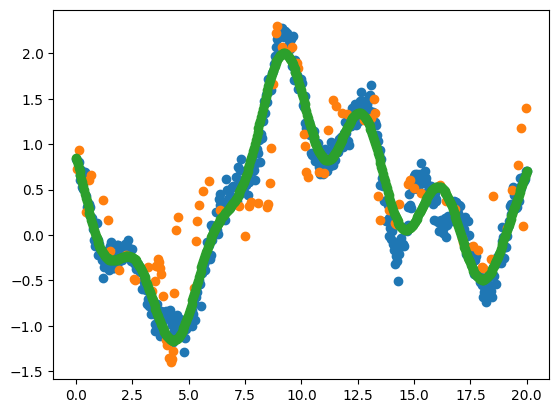

In [27]:
plt.scatter(x_obs,y_obs)
plt.scatter(Z,model.mu_u)
plt.scatter(x_obs,preds)

In [2]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SGPR_tri_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, inducing, N_u, alpha=0.5):
        super().__init__()
        self.X = X  # [N, D]
        self.y = y  # [N, 1]
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.Var_q= gpflow.Parameter(tf.linalg.eye(N_u), transform=gpflow.utilities.triangular())
        self.variance = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.sigma = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    

    def train_step(self):
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)


        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = self.Var_q@tf.transpose(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
        mu_u = tf.matmul(q1, q2)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual = self.y - K_fu@K_uu_inv @ mu_u
        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma**-2)
        term2 = 0.5 * self.alpha * tf.reduce_sum(mu_u *(Sigma_a_inv @ mu_u))
        term3 = N * tf.math.log(self.sigma)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 * (self.sigma**-2) * (tf.reduce_sum(kernel.apply(self.X, self.X)) - tf.linalg.trace(T1) +tf.linalg.trace(T2))
        term5 = -1.0/(2.0*(self.alpha-1.0)) * (ld_Sig_a + (self.alpha-1.0)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2 + term3 +term4 + term5
        return tf.squeeze(loss)

    def predict_ins(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = self.Var_q@tf.transpose(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)

        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        
        K_uu_inv = self.stable_solve(K_uu, I_M)


        return K_xu@K_uu_inv@self.mu_u
    def maximum_log_likelihood_objective(self):
        pass
# === Usage ===





In [31]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 100, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model2 = GVI_SGPR_tri_alpha(x_obs, y_obs, inducing_variable, 100)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.train_step, model.trainable_variables)
model2.predict_ins()
preds = model2.predict_out(x_obs)

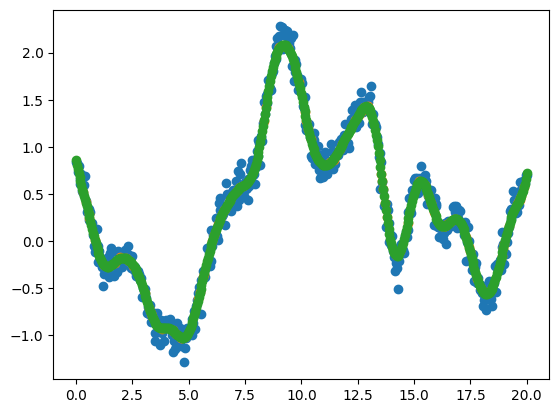

In [32]:
plt.scatter(x_obs,y_obs)
#plt.scatter(Z,model.mu_u)
plt.scatter(Z,model2.mu_u)
plt.scatter(x_obs,preds)

In [50]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SGPR_tri_lambda_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, inducing, N_u, alpha=0.5):
        super().__init__()
        self.X = X  # [N, D]
        self.y = y  # [N, 1]
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.Var_q= gpflow.Parameter(tf.linalg.eye(N_u), transform=gpflow.utilities.triangular())
        self.variance = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
        self.lambda_it = gpflow.Parameter(1.0, transform=gpflow.utilities.positive(),trainable=False)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    

    def train_step(self):
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)


        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = self.Var_q@tf.transpose(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) *self.lambda_it
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y)  *self.lambda_it
        mu_u = tf.matmul(q1, q2)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual = self.y - K_fu@K_uu_inv @ mu_u
        term1 = 0.5 * tf.reduce_sum(tf.square(residual))  *self.lambda_it
        term2 = 0.5 * self.alpha * tf.reduce_sum(mu_u *(Sigma_a_inv @ mu_u))
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 *self.lambda_it * (tf.reduce_sum(kernel.apply(self.X, self.X)) - tf.linalg.trace(T1) +tf.linalg.trace(T2))
        term5 = -1.0/(2.0*(self.alpha-1.0)) * (ld_Sig_a + (self.alpha-1.0)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2  +term4 + term5
        self.lambda_it.assign(tf.reduce_mean(residual**2/(tf.linalg.diag_part(K_fu@K_uu_inv@Sigma_u@K_uu_inv@K_uf-K_fu@K_uu_inv@K_uf)+kernel.apply(self.X, self.X))))
        return tf.squeeze(loss)

    def predict_ins(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = self.Var_q@tf.transpose(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Compute mu_u
        precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) *self.lambda_it
        q1 = tf.linalg.inv(precision_mid+jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, self.y)*self.lambda_it

        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        
        K_uu_inv = self.stable_solve(K_uu, I_M)


        return K_xu@K_uu_inv@self.mu_u
    def maximum_log_likelihood_objective(self):
        pass
# === Usage ===





In [64]:
N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 30, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_SGPR_tri_lambda_alpha(x_obs, y_obs, inducing_variable, 30)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.train_step, model.trainable_variables)
model.predict_ins()


In [69]:
tf.reduce_mean(abs(f-model.predict_out(x_obs)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.8692707420633153>

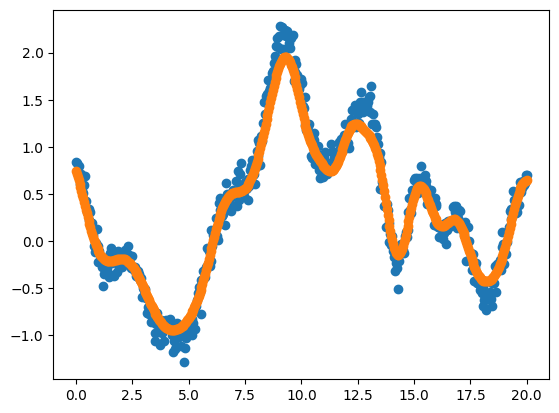

In [67]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.predict_out(x_obs))
#plt.scatter(x_obs,preds)

In [42]:
model.mu_u

<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
array([[  3.62659452],
       [ 14.84957449],
       [  2.41996946],
       [  5.34846018],
       [ -0.53788886],
       [-10.46192603],
       [-10.44386595],
       [ -2.24534425],
       [ 10.19398877],
       [ -7.67617242],
       [  1.95725404],
       [  5.9953521 ],
       [  2.01974587],
       [  4.15379474],
       [  2.42769447],
       [ -2.52120694],
       [  4.55784385],
       [ -5.09874019],
       [  6.52747182],
       [  4.52140151],
       [ -0.38455833],
       [ -5.84480963],
       [ -4.08872616],
       [ -2.42913927],
       [  2.14256248],
       [ -5.91978967],
       [  1.23946344],
       [  4.78981352],
       [  6.04315827],
       [ -5.79144967],
       [-15.84286538],
       [ 21.7713546 ],
       [  6.21437301],
       [  6.59146675],
       [  2.53295509],
       [  7.72017633],
       [  6.81112196],
       [  5.83017432],
       [ -7.55950594],
       [  3.81320007],
       [  1.3635383 ],
       

In [33]:
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 10000
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2


x_obs = np.linspace(0, 20, n_points).reshape(n_points, 1)
y_obs = np.sin(x_obs) + 0.04 * np.random.randn(n_points, 1)


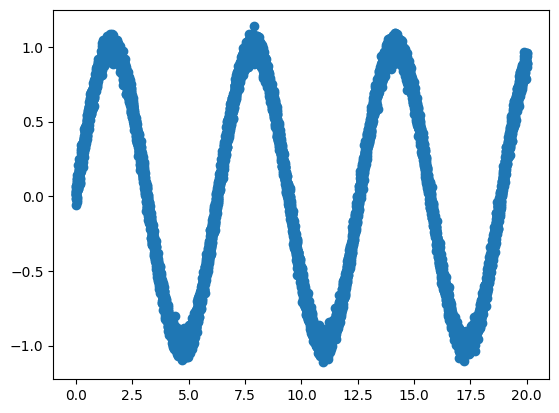

In [34]:
plt.scatter(x_obs, y_obs)

In [35]:
N=x_obs.shape[0]
N_u=100
Z = x_obs[np.random.choice(N, N_u, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_SGPR_tri_alpha(x_obs,y_obs,inducing_variable,N_u)
opt = gpflow.optimizers.Scipy()
#gpflow.set_trainable(model.q_sqrt,False)
opt.minimize(model.train_step, model.trainable_variables)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -24832.22239181299
        x: [ 8.360e-02 -5.495e-04 ... -3.073e+00 -1.069e+00]
      nit: 29
      jac: [ 1.877e+02 -9.295e+00 ...  3.077e+02  1.903e+02]
     nfev: 51
     njev: 51
 hess_inv: <5053x5053 LbfgsInvHessProduct with dtype=float64>

In [36]:
model.predict_ins()
mu=model.predict_out(x_obs)

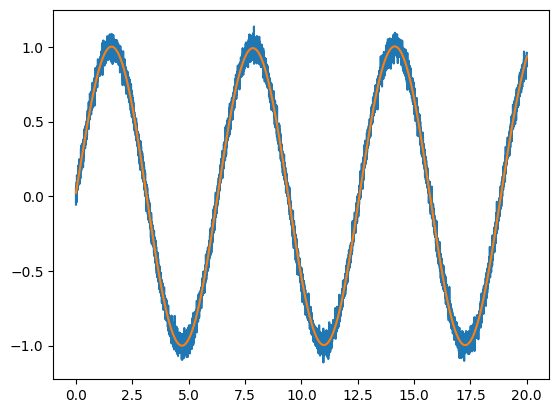

In [37]:
plt.plot(x_obs,y_obs)
plt.plot(x_obs,mu)

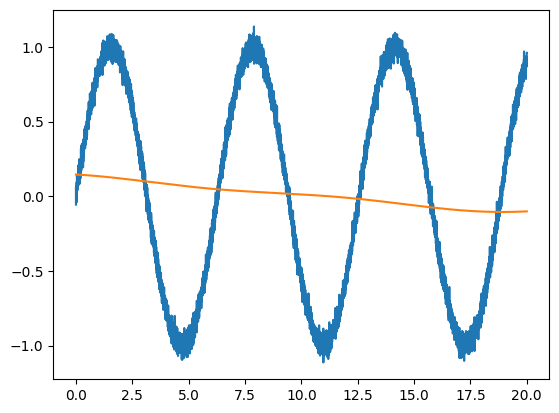

In [89]:
import matplotlib.pyplot as plt
plt.plot(x_obs,y_obs)
plt.plot(x_obs,mu)

In [90]:
standard_gp = gpflow.models.SGPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2,
    inducing_variable=Z,
)

opt = gpflow.optimizers.Scipy()
opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

f_mean, f_var = standard_gp.predict_f(x_obs, full_cov=False)

tf.reduce_mean(abs(f_mean-y_obs))

<tf.Tensor: shape=(), dtype=float64, numpy=0.03152328978942584>

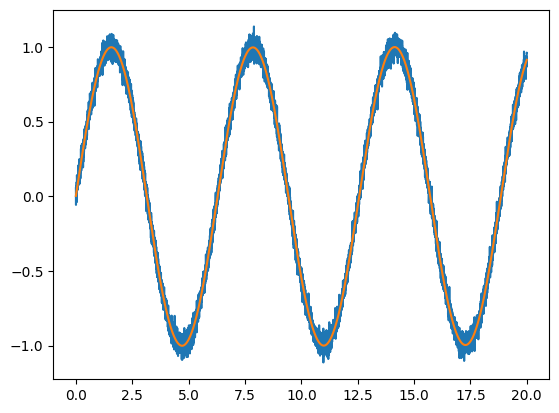

In [91]:
plt.plot(x_obs,y_obs)
plt.plot(x_obs,f_mean)

In [92]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SVGP_alpha(gpflow.models.BayesianModel):
    def __init__(self, inducing, N_u, alpha=0.5):
        super().__init__()
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.mu_q=gpflow.Parameter(tf.ones((N_u, 1)))
        self.var_q_sqrt = gpflow.Parameter(
    np.eye(N_u, dtype=np.float64)[np.newaxis,:,:],
    transform=gpflow.utilities.triangular(),
    name="q_sqrt_diagonal",
)
        
        self.variance = tf.Variable(1.0, constraint=lambda x: tf.clip_by_value(x, 1e-5, 1e5),dtype=tf.float64)
        self.lengthscale = tf.Variable(1.0, constraint=lambda x: tf.clip_by_value(x, 1e-5, 1e5),dtype=tf.float64)
        self.sigma = tf.Variable(0.1, constraint=lambda x: tf.clip_by_value(x, 1e-5, 1e2),dtype=tf.float64)

    

    def train_step(self,X,y):
        # 4) project back to SPD:
        Sigma_u = tf.squeeze(self.var_q_sqrt)@tf.transpose(tf.squeeze(self.var_q_sqrt))
        W = (Sigma_u + tf.transpose(Sigma_u)) / 2
        w, v = tf.linalg.eigh(W)
        w_clipped = tf.clip_by_value(w, 1e-6, 1e6)
        Sigma_u=(v @ tf.linalg.diag(w_clipped) @ tf.transpose(v))
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)


        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual =y - K_fu@K_uu_inv @ self.mu_q
        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma**-2)
        term2 = 0.5 * self.alpha * tf.reduce_sum(self.mu_q *(Sigma_a_inv @ self.mu_q))
        term3 = N * tf.math.log(self.sigma)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 * (self.sigma**-2) * (tf.reduce_sum(kernel.apply(X,X)) - tf.linalg.trace(T1)+tf.linalg.trace(T2))
        term5 = +1.0/(2.0*(1.0-self.alpha)) * (ld_Sig_a - (1-self.alpha)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2 + term3  + term5 +term4
        return tf.squeeze(loss)

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        K_uu_inv = tf.linalg.inv(K_uu+I_M*0.000001)
        return K_xu @ K_uu_inv @ self.mu_q
    
    def maximum_log_likelihood_objective(self):
        pass
    def training_loss(self, X, y):
        """
        This is the API GPflow’s optimizers (e.g. NaturalGradient)
        expect: a function taking (X, y) and returning a scalar loss Tensor.
        """
        return self.train_step(X, y)
# === Usage ===





In [95]:
data = tf.data.Dataset.from_tensor_slices((x_obs, y_obs))
from gpflow.optimizers import NaturalGradient


N=x_obs.shape[0]
autotune = tf.data.AUTOTUNE
batch_size = 128
n_it=1500
data_minibatch = (
    data
    .shuffle(n_it)
    .repeat()
    .batch(batch_size)
    .prefetch(autotune)
)

dataset_iter = iter(data_minibatch)


N_u=100
Z = x_obs[np.random.choice(N, N_u, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)

svgp_model=GVI_SVGP_alpha(inducing_variable,N_u)
gpflow.set_trainable(svgp_model.mu_q, False)
gpflow.set_trainable(svgp_model.var_q_sqrt, False)
# Optimizers

model_params = [
    svgp_model.variance,
    svgp_model.lengthscale,
    svgp_model.sigma,
    ]

variational_params = [(svgp_model.mu_q, svgp_model.var_q_sqrt),
]


natgrad_opt = NaturalGradient(gamma=0.00001)

for step in range(n_it):
    X_batch, y_batch = next(dataset_iter)
    print(svgp_model.inducing_variable.dtype)
    with tf.GradientTape() as tape:
        grad = tape.gradient(svgp_model.train_step(X_batch, y_batch), svgp_model.trainable_variables)
    optimizer = tf.optimizers.Adam(0.01)
    optimizer.apply_gradients(zip(grad,svgp_model.trainable_variables))
    natgrad_opt.minimize(lambda:svgp_model.train_step(X_batch, y_batch), var_list=variational_params)







<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'flo

10000

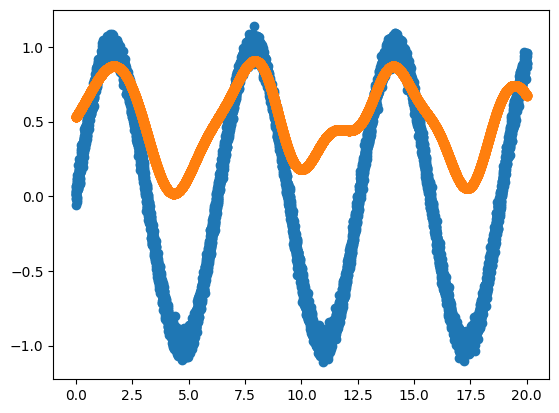

In [99]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,svgp_model.predict_out(x_obs))

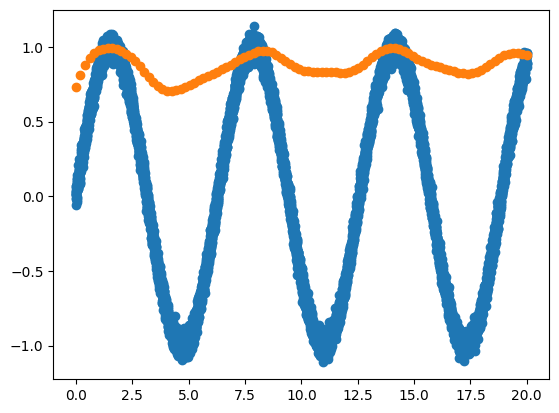

In [107]:
plt.scatter(x_obs,y_obs)
Z1 = np.linspace(0, 20, 100)[ :,np.newaxis]
mu_1=svgp_model.predict_out(Z1)
plt.scatter(Z1,mu_1)


THIS IS THE ONE WITH NO BATCHING

In [46]:
import time
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SVGP_myNatgrad_alpha(gpflow.models.BayesianModel):
    def __init__(self,X,y, inducing, N_u, alpha=0.5):
        super().__init__()
        self.X=X
        self.y=y
        self.inducing_variable = inducing
        self.N_u = N_u

        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        self.mu_q=gpflow.Parameter(tf.ones((N_u, 1)),trainable=False)
        self.Var_q = tf.Variable(np.eye(N_u),trainable=False)
        
        self.variance = tf.Variable(1.0, constraint=lambda x: tf.clip_by_value(x, 1e-5, 1e5),dtype=tf.float64)
        self.lengthscale = tf.Variable(1.0, constraint=lambda x: tf.clip_by_value(x, 1e-5, 1e5),dtype=tf.float64)
        self.sigma = tf.Variable(0.1, constraint=lambda x: tf.clip_by_value(x, 1e-5, 1e2),dtype=tf.float64)

    
    @tf.function
    def train_step(self):
        # Build kernel matrices
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)


        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu+jitter)

        # Variational covariances
        Sigma_u = self.Var_q
        Sigma_u_inv = tf.linalg.inv(Sigma_u+jitter)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu+jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a+jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u+jitter)

        # Loss components
        residual =self.y - K_fu@K_uu_inv @ self.mu_q
        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma**-2)
        term2 = 0.5 * self.alpha * tf.reduce_sum(self.mu_q *(Sigma_a_inv @ self.mu_q))
        term3 = N * tf.math.log(self.sigma)
        T1 = K_uu_inv @ (K_uf @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        term4 = 0.5 * (self.sigma**-2) * (tf.reduce_sum(kernel.apply(self.X,self.X)) - tf.linalg.trace(T1)+tf.linalg.trace(T2))
        term5 = +1.0/(2.0*(1.0-self.alpha)) * (ld_Sig_a - (1-self.alpha)*ld_Sig_u - self.alpha*ld_K)
        
        loss = term1 + term2 + term3  + term5 +term4

        return tf.squeeze(loss)
    
    

    def predict_out(self, Xnew):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        K_uu_inv = tf.linalg.inv(I_M+K_uu)
        return K_xu @ K_uu_inv @ self.mu_q

    
    def maximum_log_likelihood_objective(self):
        pass
    
    def training_loss(self,n_it=200,l_r=0.01):
        optimizer = tf.optimizers.Adam(l_r)
        for i in range(n_it):
            with tf.GradientTape() as tape:
                grad = tape.gradient(svgp_model.train_step(), svgp_model.trainable_variables)
            optimizer.apply_gradients(zip(grad,self.trainable_variables))
                    
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
            K_uu = kernel.matrix(self.inducing_variable, self.inducing_variable)
            K_uf = kernel.matrix(self.inducing_variable, self.X)
            K_fu = tf.transpose(K_uf)
            
            
    
    
            # Invert via stable_solve
            jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
            K_uu_inv = tf.linalg.inv(K_uu+jitter)
            

            # Variational covariances
            Sigma_u = self.Var_q
            Sigma_u_inv = tf.linalg.inv(Sigma_u+jitter)
            Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
            Sigma_a_inv = tf.linalg.inv(Sigma_a+jitter)
            
            # Compute mu_u
            precision_mid = self.alpha * Sigma_a_inv + (K_uu_inv @ K_uf @ K_fu @ K_uu_inv) / (self.sigma**2)
            q1 = tf.linalg.inv(precision_mid+jitter)
            q2 = tf.matmul(K_uu_inv @ K_uf, self.y) / (self.sigma**2)
            self.mu_q = tf.matmul(q1, q2)
            
            trace_term = 0.5*self.sigma**(-2) * (K_uu_inv @ K_uf @ K_fu @ K_uu_inv)
            prior_cross = - self.alpha*(1-self.alpha)/2 * (Sigma_a_inv @ self.mu_q @ tf.transpose(self.mu_q) @ Sigma_a_inv)
            kl_term    = -0.5 * Sigma_a_inv
            kl_prior   = +0.5 * Sigma_u_inv
            
            euclid_grad_sigma = trace_term  + kl_term + kl_prior+ prior_cross

            
            # 3) update with natural gradient:
    
            #rho_s = 0.1 / (1 + i / 1000)
            rho_s=1
            S_new = Sigma_u+ rho_s *Sigma_u@(Sigma_u_inv-K_uu_inv)@Sigma_u
            # 4) project back to SPD:
            W = (S_new + tf.transpose(S_new)) / 2
            w, v = tf.linalg.eigh(W)
            w_clipped = tf.clip_by_value(w, 1e-6, 1e6)
            self.Var_q.assign(v @ tf.linalg.diag(w_clipped) @ tf.transpose(v))

        
    

        
# === Usage ===





In [47]:

N_u=100
Z = x_obs[np.random.choice(N, N_u, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)

svgp_model=GVI_SVGP_myNatgrad_alpha(x_obs,y_obs,inducing_variable,N_u,0.1)

In [48]:
svgp_model.training_loss(300)

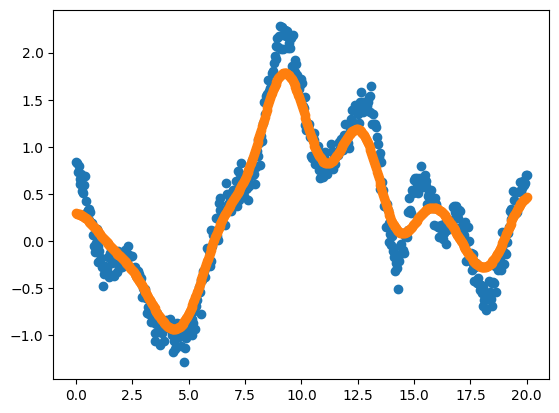

In [49]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,svgp_model.predict_out(x_obs))

In [349]:
svgp_model.Var_q

<tf.Variable 'Variable:0' shape=(100, 100) dtype=float64, numpy=
array([[ 3.60396892e+05,  7.63070816e+03, -1.43379523e+04, ...,
         2.46116682e+02, -1.98851287e+04,  3.50999994e+04],
       [ 7.63070816e+03,  7.56121743e+05,  5.62610303e+03, ...,
        -2.03788948e+04, -3.52999860e+04, -3.74231661e+04],
       [-1.43379523e+04,  5.62610303e+03,  6.73430395e+05, ...,
        -6.22719509e+04,  1.42409791e+05,  6.50409485e+04],
       ...,
       [ 2.46116682e+02, -2.03788948e+04, -6.22719509e+04, ...,
         8.74072371e+05,  1.44174238e+04,  3.36583673e+04],
       [-1.98851287e+04, -3.52999860e+04,  1.42409791e+05, ...,
         1.44174238e+04,  4.65050474e+05, -4.04682838e+04],
       [ 3.50999994e+04, -3.74231661e+04,  6.50409485e+04, ...,
         3.36583673e+04, -4.04682838e+04,  8.98218630e+05]])>

In [34]:
data = tf.data.Dataset.from_tensor_slices((x_obs, y_obs))
from gpflow.optimizers import NaturalGradient


N=x_obs.shape[0]
autotune = tf.data.AUTOTUNE
batch_size = 128
n_it=200
data_minibatch = (
    data
    .shuffle(n_it)
    .repeat()
    .batch(batch_size)
    .prefetch(autotune)
)

dataset_iter = iter(data_minibatch)


N_u=100
Z = x_obs[np.random.choice(N, N_u, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)

svgp_model=GVI_SVGP_myNatgrad_alpha(inducing_variable,N_u)








TypeError: GVI_SVGP_myNatgrad_alpha.__init__() missing 2 required positional arguments: 'inducing' and 'N_u'

In [101]:
svgp_model.training_loss(x_obs,y_obs)  

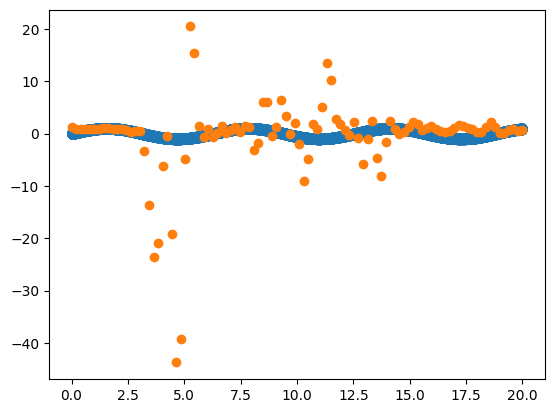

In [102]:
plt.scatter(x_obs,y_obs)
Z1 = np.linspace(0, 20, 100)[ :,np.newaxis]
mu_1=svgp_model.predict_out(Z1)
plt.scatter(Z1,mu_1)

In [388]:
model.predict_ins()

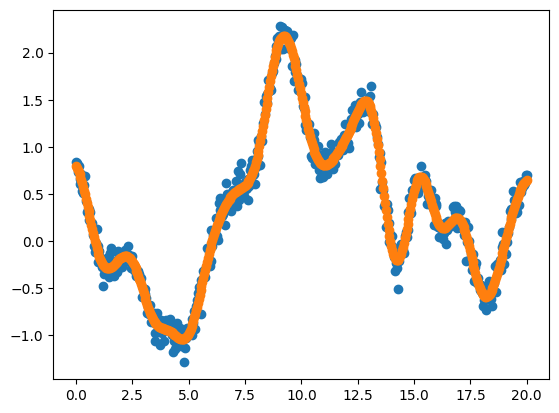

In [389]:
plt.scatter(x_obs,y_obs)
plt.scatter(x_obs,model.mu_f)

In [390]:
model.Sigma_f[1:10,1:10]

<tf.Tensor: shape=(9, 9), dtype=float64, numpy=
array([[ 2.58569264e+00, -8.22244649e-12,  3.06772535e-10,
         6.85548230e-01,  3.56940546e-10,  1.46233203e-08,
         5.23661183e-01,  2.10958009e-02,  7.12283995e-10],
       [-8.22252574e-12,  2.58569264e+00,  1.65271308e+00,
         3.96474518e-10,  2.25859020e-09,  9.95796189e-06,
        -1.13242165e-09,  3.27355114e-10,  1.89492116e+00],
       [ 3.06772577e-10,  1.65271308e+00,  2.58569264e+00,
         2.66348707e-12,  2.54722987e-09,  5.79950719e-08,
        -6.61323242e-10,  7.26407212e-10,  2.55374371e+00],
       [ 6.85548230e-01,  3.96474519e-10,  2.66350625e-12,
         2.58569263e+00, -4.98030147e-10,  1.66950159e-09,
         7.54817391e-03,  3.57366692e-05, -6.12855312e-10],
       [ 3.56940531e-10,  2.25859021e-09,  2.54722987e-09,
        -4.98030135e-10,  2.58569261e+00,  7.66346009e-10,
         5.31333320e-10,  4.25943203e-10,  9.46200411e-11],
       [ 1.46233202e-08,  9.95796189e-06,  5.79950719e-08,
   

In [54]:
tf.linalg.diag_part(model.Sigma_f)


<tf.Tensor: shape=(500,), dtype=float64, numpy=
array([0.01809846, 0.0180983 , 0.01809823, 0.01809845, 0.01809629,
       0.01809832, 0.0180984 , 0.01809835, 0.01809826, 0.01809831,
       0.01809335, 0.01809815, 0.0180972 , 0.01809824, 0.01809813,
       0.01809837, 0.01809848, 0.01809661, 0.01809817, 0.01804498,
       0.01809821, 0.01805593, 0.01809754, 0.01809808, 0.01809781,
       0.01809806, 0.01809821, 0.01809841, 0.01809632, 0.01809795,
       0.01809826, 0.01806673, 0.01809629, 0.01809744, 0.01809146,
       0.01809815, 0.01809827, 0.0180984 , 0.01809822, 0.01809842,
       0.01809839, 0.01809719, 0.01809827, 0.01805581, 0.01809747,
       0.01809739, 0.01809788, 0.0180947 , 0.0180969 , 0.01809808,
       0.01809733, 0.01809812, 0.01809831, 0.01809834, 0.01809785,
       0.01809656, 0.01809833, 0.01809848, 0.01809437, 0.01809827,
       0.01809807, 0.0180984 , 0.01809786, 0.01809824, 0.01809664,
       0.01809238, 0.01809842, 0.01809723, 0.01809839, 0.01809837,
       0.01809

In [52]:
f_var**0.5

<tf.Tensor: shape=(500, 1), dtype=float64, numpy=
array([[0.02380005],
       [0.02380065],
       [0.02380011],
       [0.02380024],
       [0.02380598],
       [0.02526069],
       [0.02380005],
       [0.02380011],
       [0.02380007],
       [0.02380022],
       [0.02382005],
       [0.02380064],
       [0.02380131],
       [0.02380309],
       [0.02694248],
       [0.02380029],
       [0.02380005],
       [0.02383466],
       [0.02380191],
       [0.03388486],
       [0.02386233],
       [0.02381905],
       [0.02380006],
       [0.02380006],
       [0.02586847],
       [0.02387553],
       [0.02380005],
       [0.02380011],
       [0.02380271],
       [0.02380068],
       [0.02399746],
       [0.02382139],
       [0.02526069],
       [0.02380172],
       [0.02447867],
       [0.02380005],
       [0.02380009],
       [0.02380007],
       [0.02380064],
       [0.02380005],
       [0.02394568],
       [0.0271029 ],
       [0.02380007],
       [0.02381886],
       [0.0238009 ],
     

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import openml



def load_concrete_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    df = pd.read_excel(url)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y


def load_energy_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    df = pd.read_excel(url)
    X = df.iloc[:, :8].values
    y = df.iloc[:, 8].values  # Heating load
    return X, y


def load_yacht_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data"
    df = pd.read_csv(url, delim_whitespace=True, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y


def load_kin8nm_dataset():
    dataset = openml.datasets.get_dataset(189)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    return X.values, y.values


def normalize_split(X, y, test_size=0.2, seed=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
    return X_train, X_test, y_train, y_test


# Dict of dataset loaders
dataset_loaders = {
    "concrete": load_concrete_dataset,
    "energy": load_energy_dataset,
    "yacht": load_yacht_dataset,
}

loss_st = []
loss_a = []
# Loop through all datasets<
for name, loader in dataset_loaders.items():
    try:
        X, y = loader()
        y = y.reshape(-1, 1)
        X_train, X_test, y_train, y_test = normalize_split(X, y)
        y_test = y_test.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        standard_gp = gpflow.models.GPR(
            (X_train, y_train),
            kernel=gpflow.kernels.SquaredExponential(lengthscales=1., variance=1.),
            noise_variance=1.)

        opt = gpflow.optimizers.Scipy()
        opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

        f_mean, f_var = standard_gp.predict_f(X_test, full_cov=False)

        print("standand gp",tf.reduce_mean((f_mean - y_test) ** 2))

        N = X_train.shape[0]
        np.random.seed(0)
        num_inducing = min(100, X_train.shape[0])  # or 50, but must be ≤ X_train rows
        Z = X_train[np.random.choice(X_train.shape[0], num_inducing, replace=False), :]

        inducing_variable = gpflow.Parameter(Z, trainable=False)
        """ 
        model = GVI_GP_alpha(X_train, y_train, inducing_variable)
        gpflow.set_trainable(model.alpha, False)
        model.internal_opt(20)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model.train_step, model.trainable_variables)

        
        model.predict_ins()
        f_mean = model.predict_out(X_test)
        print("GVI a gp",tf.reduce_mean((f_mean - y_test) ** 2))"""
        
        model = GVI_GP_MSE_alpha(X_train, y_train, inducing_variable)
        model.internal_opt(100)

        
        model.predict_ins()
        f_mean = model.predict_out(X_test)
        print("GVI a gp MSE",tf.reduce_mean((f_mean - y_test) ** 2))
        """
        inducing_variable = gpflow.Parameter(Z, trainable=False)
        model = GVI_GP_lambda_pred_alpha(X_train, y_train, inducing_variable)
        gpflow.set_trainable(model.alpha, False)
        opt = gpflow.optimizers.Scipy()
        model.internal_opt(20)
        gpflow.set_trainable(model.inducing_variable, False)
        opt.minimize(model.train_step, model.trainable_variables)
        model.predict_ins()
        f_mean = model.predict_out(X_test)
        print("Pred",tf.reduce_mean((f_mean - y_test) ** 2))
        
        
        model_2=GVI_SGPR_tri_lambda_alpha(X_train, y_train,inducing_variable, num_inducing,alpha=0.5)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model_2.train_step, model_2.trainable_variables)
        
        
        model_2.predict_ins()
        f_mean=model_2.predict_out(X_test)
        print(tf.reduce_mean((f_mean-y_test)**2))
        """

    except Exception as e:
        print(f"Failed to load {name}: {e}")

standand gp tf.Tensor(0.11011516334629493, shape=(), dtype=float64)
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<

/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_3569/769918820.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None)


standand gp tf.Tensor(0.00036400845221566615, shape=(), dtype=float64)
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'>
<dtype: 'float64'

In [17]:

import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_MSE_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing,alpha=0.5,lengthscale=1.,variance=1.):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable= False)
        # GP parameters
        self.kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale,variance=variance)
        self.inducing_variable = inducing
        self.lambda_i = gpflow.Parameter(10,transform=gpflow.utilities.positive(),trainable=False)
        #self.sigma=tf.Variable(0.3,dtype=tf.float64,trainable=False)
        self.a_p = tf.constant(1.0,dtype=tf.float64)
        self.b_p = tf.constant(1.0,dtype=tf.float64)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)

    def maximum_log_likelihood_objective(self):
        pass


    def train_step(self):

        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)
        
        #
        self.lambda_i.assign(N+1/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))

        # Loss terms
        term1 =  tf.transpose(self.y-mu_f) @ (eye *self.lambda_i**2) @ (self.y-mu_f)
        term4 = self.lambda_i**2* tf.linalg.trace(Sigma_f)-N*self.lambda_i
        term3 = -tfp.distributions.Gamma(self.a_p,self.b_p).log_prob(self.lambda_i)

        term2= 0.5 * self.alpha* tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 +term2 +term3 + term4 + term5)
        return loss
        

    def predict_ins(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)
        self.mu_f=mu_f
        self.Sigma_f=Sigma_f
        self.K=K

    def update_lambda(self):
        K = self.kernel(self.X, self.X)
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf

        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6


        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + eye *(self.lambda_i**2))
        q2 = tf.matmul(eye *self.lambda_i**2, self.y)
        mu_f= tf.matmul(q1, q2)

        self.lambda_i.assign(N+1/(tf.reduce_sum((self.y-mu_f)**2+tf.linalg.trace(Sigma_f))))
        
    def internal_opt(self,n_it=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))


    def predict_out(self,X):
        K_xold_xold = self.kernel(self.X,self.X)
        K_xold_xnew=self.kernel(X,self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)
        return K_xold_xnew @ K_inv @ self.mu_f



In [30]:
model = GVI_GP_MSE_alpha(X_train, y_train, inducing_variable)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
f_mean = model.predict_out(X_test)
print("GVI a gp MSE",tf.reduce_mean((f_mean - y_test) ** 2))

<dtype: 'float64'>
<dtype: 'float64'>
GVI a gp MSE tf.Tensor(0.233397571707152, shape=(), dtype=float64)


In [27]:
model.trainable_variables

(<tf.Variable 'Variable:0' shape=(50, 8) dtype=float64, numpy=
 array([[ 2.03625858e+00, -1.21300369e-01, -6.91491010e-02,
         -1.38533636e+00,  2.49975089e-01,  4.06077566e-01,
         -1.19727244e+00,  5.55544981e-01],
        [-2.27668923e-01, -1.42615265e+00, -3.54977402e-01,
         -4.35465872e-01, -5.53629049e-01,  1.11569003e+00,
          9.13840227e-01,  2.08045937e-01],
        [-5.61957542e-01, -9.95560032e-02, -1.34882532e+00,
          2.63944435e+00, -1.55935424e+00, -1.00280015e+00,
         -8.46132807e-01,  1.24590249e+00],
        [-1.19270935e+00, -2.80091359e-01,  1.74491377e+00,
          1.55110947e+00, -1.17833254e+00, -8.76090978e-01,
         -4.84236349e-02, -1.13847988e+00],
        [ 6.27518781e-01, -1.42254570e+00, -1.39917510e+00,
         -3.36846328e-01, -1.62835774e+00,  1.19607947e-01,
         -1.09814021e-01, -1.23552337e+00],
        [ 4.20802730e-02, -4.10650669e-01,  5.90255709e-01,
         -7.25315413e-01, -3.76391857e-01,  1.55426533e+0

In [31]:
f_mean, f_var = standard_gp.predict_f(X_test, full_cov=False)
        

In [32]:
print(tf.reduce_mean(abs(f_mean-y_test)))

tf.Tensor(0.03846010388822682, shape=(), dtype=float64)


In [35]:
tf.reduce_mean(abs(model.mu_f - y_train))

<tf.Tensor: shape=(), dtype=float64, numpy=0.13760117677858422>

In [34]:
mu,s=standard_gp.predict_f(X_train, full_cov=True)
tf.reduce_mean((mu - y_train) ** 2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0011335730566614658>

In [9]:
model.alpha

<Parameter: name=identity, dtype=float64, shape=[], fn="identity", numpy=-6.140041290144067e-07>

In [42]:
model = GVI_GP_lambda_pred_alpha(X_train, y_train, inducing_variable)
opt = gpflow.optimizers.Scipy()
gpflow.set_trainable(model.alpha, False)
model.internal_opt(20)

opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
f_mean = model.predict_out(X_test)
print(tf.reduce_mean((f_mean - y_test) ** 2))
        

Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
tf.Tensor(0.021267030658806314, shape=(), dtype=float64)


<Parameter: name=identity, dtype=float64, shape=[], fn="identity", numpy=0.5>

In [19]:
Z = X_train[np.random.choice(X_train.shape[0], num_inducing, replace=False), :]
inducing_variable = gpflow.Parameter(Z, trainable=True)
model = GVI_GP_lambda_pred_alpha(X_train, y_train, inducing_variable)
#model.internal_opt(50)
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
f_mean = model.predict_out(X_test)


print(tf.reduce_mean((f_mean - y_test) ** 2))

Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
tf.Tensor(0.002833766982902908, shape=(), dtype=float64)


In [30]:
opt = gpflow.optimizers.Scipy()
model = GVI_GP_lambda_2K_pred_alpha(X_train, y_train)
#model.internal_opt(50)
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
f_mean = model.predict_out(X_test)
print(tf.reduce_mean((f_mean - y_test) ** 2))
model.alpha

Tensor("Cast:0", shape=(), dtype=float64)
<dtype: 'float64'>
tf.Tensor(0.06414391633886705, shape=(), dtype=float64)


<Parameter: name=identity, dtype=float64, shape=[], fn="identity", numpy=-1.2794752947301462e-06>

In [21]:
model = GVI_GP_alpha(X_train, y_train, inducing_variable)
model.internal_opt(100)
model.predict_ins()
f_mean = model.predict_out(X_test)
print(tf.reduce_mean((f_mean - y_test) ** 2))

<dtype: 'float64'>
<dtype: 'float64'>
tf.Tensor(0.09994114271183775, shape=(), dtype=float64)


In [48]:
standard_gp = gpflow.models.GPR(
            (X_train, y_train),
            kernel=gpflow.kernels.SquaredExponential(lengthscales=1., variance=1.),
            noise_variance=1.)
opt = gpflow.optimizers.Scipy()
opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

f_mean, f_var = standard_gp.predict_f(X_test, full_cov=False)
print(tf.reduce_mean((f_mean - y_test) ** 2))

tf.Tensor(0.00036400845221566615, shape=(), dtype=float64)


In [51]:
K=standard_gp.kernel

In [54]:
standard_gp.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=1.4038964079277358>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=14.562774311490138>,
 <tf.Variable 'chain_of_shift_of_softplus:0' shape=() dtype=float64, numpy=-8.967015285465601>)

In [56]:
np.sqrt(np.log(np.exp(-8.96)+1))

0.01133304924636728

In [71]:
Z = X_train[np.random.choice(X_train.shape[0], 50, replace=False), :]
inducing_variable = gpflow.Parameter(Z, trainable=False)
model = GVI_GP_alpha(X_train, y_train, inducing_variable)
model.internal_opt(1000)

model.predict_ins()
f_mean = model.predict_out(X_test)
print(tf.reduce_mean((f_mean - y_test) ** 2))

<dtype: 'float64'>
<dtype: 'float64'>
tf.Tensor(0.10620160474558171, shape=(), dtype=float64)


In [69]:
X_train.shape

(246, 6)

In [52]:
Z = X_train[np.random.choice(X_train.shape[0], num_inducing, replace=False), :]
inducing_variable = gpflow.Parameter(Z, trainable=True)
model = GVI_GP_alpha_Kinput(X_train, y_train, inducing_variable,K,)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.train_step, model.trainable_variables)
model.predict_ins()
f_mean = model.predict_out(X_test)


print(tf.reduce_mean((f_mean - y_test) ** 2))

NameError: name 'sigma' is not defined

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import openml



def load_concrete_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    df = pd.read_excel(url)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y


def load_energy_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    df = pd.read_excel(url)
    X = df.iloc[:, :8].values
    y = df.iloc[:, 8].values  # Heating load
    return X, y


def load_yacht_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data"
    df = pd.read_csv(url, delim_whitespace=True, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y


def load_kin8nm_dataset():
    dataset = openml.datasets.get_dataset(189)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    return X.values, y.values


def normalize_split(X, y, test_size=0.2, seed=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
    return X_train, X_test, y_train, y_test


# Dict of dataset loaders
dataset_loaders = {
    "concrete": load_concrete_dataset,
    "energy": load_energy_dataset,
    "yacht": load_yacht_dataset,
}

loss_st = []
loss_a = []
# Loop through all datasets<
for name, loader in dataset_loaders.items():
    try:
        X, y = loader()
        y = y.reshape(-1, 1)
        X_train, X_test, y_train, y_test = normalize_split(X, y)
        y_test = y_test.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        N = X_train.shape[0]
        np.random.seed(0)
        N=X_train.shape[0]
        Z = X_train[np.random.choice(N, 40, replace=False), :]
        standard_gp = gpflow.models.SGPR(
            (X_train, y_train),
            kernel=gpflow.kernels.SquaredExponential(lengthscales=1., variance=1.),
            noise_variance=1.,inducing_variable=Z)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

        f_mean, f_var = standard_gp.predict_f(X_test, full_cov=False)
        print("S gpr",tf.reduce_mean((f_mean - y_test) ** 2))

        N = X_train.shape[0]
        
        # --- define kernel and likelihood ---
        kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
        likelihood = gpflow.likelihoods.Gaussian(variance=1.0)
        
        # --- build the SVGP model ---
        svgp = gpflow.models.SVGP(
            kernel=kernel,
            likelihood=likelihood,
            inducing_variable=Z,
            num_latent_gps=1,          # one latent function for scalar regression
        )
        
        # --- set up Scipy optimizer on the ELBO ---
        opt = gpflow.optimizers.Scipy()
        
        # Create a closure so Scipy knows how to evaluate the negative ELBO:
        data = (X_train, y_train)
        training_loss = svgp.training_loss_closure(data)
        
        # Minimize (i.e., maximize ELBO)
        opt.minimize(training_loss, variables=svgp.trainable_variables)
        
        # --- make predictions just like SGPR ---
        # full_cov=False returns only marginal variances
        f_mean, f_var = svgp.predict_f(X_test, full_cov=False)
        print("Svgp",tf.reduce_mean((f_mean - y_test) ** 2))

        inducing_variable = gpflow.Parameter(Z,trainable=True)
        model2 = GVI_SGPR_tri_alpha(X_train, y_train, inducing_variable, 40)
        optimizer = gpflow.optimizers.Scipy()
        optimizer.minimize(model2.train_step, model2.trainable_variables)
        model2.predict_ins()
        preds = model2.predict_out(X_test)
        print("alpha gp",tf.reduce_mean((preds - y_test) ** 2))

    except Exception as e:
        print(f"Failed to load {name}: {e}")

S gpr tf.Tensor(0.15283972218489897, shape=(), dtype=float64)
Svgp tf.Tensor(0.15060160050397736, shape=(), dtype=float64)
alpha gp tf.Tensor(0.2657819118729067, shape=(), dtype=float64)
S gpr tf.Tensor(0.02592662958848677, shape=(), dtype=float64)
Svgp tf.Tensor(0.03378995916423665, shape=(), dtype=float64)
alpha gp tf.Tensor(0.0030413665602195107, shape=(), dtype=float64)


/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_4307/3733095220.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None)


S gpr tf.Tensor(0.010963171422417607, shape=(), dtype=float64)
Svgp tf.Tensor(0.012002437844803674, shape=(), dtype=float64)
alpha gp tf.Tensor(0.00843609318300674, shape=(), dtype=float64)


In [20]:
Z

array([[ 0.10711548,  0.08588519, -0.05339129,  2.55311235, -1.81845651,
         1.34385515],
       [ 0.10711548,  0.21550332, -0.05339129,  0.08462907, -0.14897241,
        -1.08694166],
       [ 0.10711548,  0.25870936, -0.05339129, -1.63967909,  1.76482645,
        -1.08694166],
       [ 1.63756846, -1.42632638, -0.05339129, -0.35098562, -0.23041066,
        -1.57310103],
       [ 0.10711548, -1.42632638, -1.78365273, -2.05714318, -0.23041066,
         1.58693483],
       [-1.68950323,  1.59809675, -0.05339129,  0.53839438, -0.23041066,
        -1.08694166],
       [-1.68950323,  1.59809675, -0.05339129,  0.53839438, -0.23041066,
         0.85769579],
       [-1.68950323,  0.08588519, -0.09271541,  0.08462907, -0.23041066,
         0.6146161 ],
       [-1.68950323, -1.42632638, -0.05339129, -0.35098562, -0.23041066,
        -1.08694166],
       [-1.68950323, -1.42632638, -0.05339129, -0.35098562, -0.23041066,
        -0.6007823 ],
       [ 0.04057405,  0.21550332, -1.78365273, -1.

In [21]:
standard_gp.trainable_variables

(<tf.Variable 'Variable:0' shape=(40, 6) dtype=float64, numpy=
 array([[ 1.07650682e-01,  7.77392616e-02, -4.98096238e-02,
          2.53415642e+00, -1.80468937e+00, -8.55006315e-01],
        [ 4.16621205e-01, -2.01271382e-02, -2.68702835e-02,
          4.18978733e-02, -1.23884333e-01, -2.17277856e-01],
        [ 1.07498801e-01,  2.58351929e-01, -4.63489085e-02,
         -1.62355706e+00,  1.75372414e+00, -5.44553292e-01],
        [ 1.58359145e+00, -1.19591087e+00, -7.29940469e-02,
         -2.80914333e-01, -2.40920837e-01, -1.07192289e+00],
        [ 6.25675604e-01, -7.61478041e-01, -7.24439271e-02,
         -1.90662440e-01, -1.84824758e-01,  2.85978615e+00],
        [-1.71746950e+00,  1.57962623e+00, -5.39844255e-02,
          5.31026395e-01, -2.23614867e-01, -5.23916393e-01],
        [ 1.06966858e-01,  1.64068166e+00, -1.77975218e+00,
          5.41147015e-01, -1.94418507e+00,  5.60100047e-01],
        [-1.68519805e+00,  9.59185203e-02,  1.19465782e+00,
         -1.00598996e-03,  1.2

In [22]:
model2.trainable_variables

(<tf.Variable 'fill_triangular:0' shape=(820,) dtype=float64, numpy=
 array([-1.85663557e-02, -7.05927669e-03, -7.59830322e-04, -6.88997249e-03,
         4.31203223e-04, -2.72440041e-03,  2.13949517e-03,  1.65097642e-03,
        -3.00197356e-03,  1.01249651e-03,  7.10168429e-05, -8.65243373e-04,
         1.94377798e-03, -2.15366072e-03,  2.45871150e-03, -1.59876218e-03,
         1.31952905e-03,  2.12169584e-02, -1.19487480e-02,  3.28972564e-03,
         3.62830050e-03, -3.38582614e-03,  3.51134834e-03,  7.63117743e-04,
        -5.69208211e-03,  3.64032961e-04,  6.03228715e-03, -3.26028922e-03,
         2.78133974e-02, -1.59387682e-02,  3.27468488e-03, -2.20370289e-02,
         2.17524091e-02, -1.72829005e-02,  1.77817950e-02, -2.77106123e-02,
        -2.27194778e-03, -1.33350719e-02,  1.61451253e-02, -3.12131284e-01,
         6.70178040e-01,  1.88152238e-02,  2.42674944e-03, -3.87462419e-04,
         2.48678360e-03,  2.22521547e-03, -3.87264096e-03,  4.06041095e-03,
         1.49325795

In [27]:
svgp.trainable_variables

(<tf.Variable 'Variable:0' shape=(40, 1) dtype=float64, numpy=
 array([[ 0.11599503],
        [-0.27534429],
        [ 0.20885147],
        [ 0.03445051],
        [ 1.02130246],
        [ 0.5091261 ],
        [-0.07637303],
        [ 0.75205793],
        [-0.65358197],
        [ 0.09391652],
        [-0.32083454],
        [-0.56067651],
        [ 3.63534221],
        [-1.11715325],
        [ 0.54075085],
        [-1.49079226],
        [ 1.65841404],
        [-1.53757316],
        [-2.44343692],
        [-1.10452153],
        [ 0.65948592],
        [-3.6236383 ],
        [-1.14154407],
        [ 1.10821158],
        [ 0.82093558],
        [-7.92610397],
        [ 0.98057741],
        [-0.59204745],
        [-0.31985246],
        [-1.91674625],
        [-0.77581308],
        [ 4.35419522],
        [ 0.65316235],
        [ 0.07578778],
        [ 0.39302539],
        [-0.93323719],
        [-0.08560978],
        [ 0.41829639],
        [ 0.14157556],
        [ 0.34691407]])>,
 <tf.Variable 

In [29]:

model = GVI_GP_myNatgrad_full_alpha(X_train,y_train)
model.training_loss()

In [30]:
model.predict_ins()

In [31]:
pred=model.predict_out(X_test)

In [32]:
print("alpha gp",tf.reduce_mean((pred - y_test) ** 2))

alpha gp tf.Tensor(0.08195719908793135, shape=(), dtype=float64)


AttributeError: 'tuple' object has no attribute 'shuffle'

In [61]:
import numpy as np
import tensorflow as tf
import gpflow

# --- assume X_train, y_train, X_test are already defined ---
N = X_train.shape[0]
batch_size = 128
n_iterations = 10000

# --- build a tf.data pipeline ---
train_dataset = (
    tf.data.Dataset
       .from_tensor_slices((X_train, y_train))
       .shuffle(buffer_size=N)
       .repeat()                         # infinite stream
       .batch(batch_size)
       .prefetch(tf.data.AUTOTUNE)
)
train_iter = iter(train_dataset)

# --- inducing points setup ---
N_u = 100
Z_init = X_train[np.random.choice(N, N_u, replace=False), :]
# As in your snippet, we wrap Z in a trainable Parameter if you like:
inducing_variable = gpflow.inducing_variables.InducingPoints(Z_init)

# --- kernel & likelihood ---
kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
likelihood = gpflow.likelihoods.Gaussian(variance=1.0)

# --- SVGP model (or your GVI_SVGP_alpha) ---
svgp = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=1,
)

# --- optimizer ---
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# --- one step of variational‐ELBO maximization ---
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        # compute negative ELBO on this minibatch
        loss = -svgp.elbo((x_batch, y_batch))
    grads = tape.gradient(loss, svgp.trainable_variables)
    optimizer.apply_gradients(zip(grads, svgp.trainable_variables))
    return loss

# --- training loop ---
for step in range(1, n_iterations + 1):
    x_batch, y_batch = next(train_iter)
    loss = train_step(x_batch, y_batch)
    if step % 20 == 0:
        print(f"Step {step:4d}, ELBO = {-loss:.4f}")

# --- prediction (same API as SGPR) ---
f_mean, f_var = svgp.predict_f(X_test, full_cov=False)


Step   20, ELBO = -190.9323
Step   40, ELBO = -186.1232
Step   60, ELBO = -174.6907
Step   80, ELBO = -160.8591
Step  100, ELBO = -148.6395
Step  120, ELBO = -144.7492
Step  140, ELBO = -133.2174
Step  160, ELBO = -133.5593
Step  180, ELBO = -130.3468
Step  200, ELBO = -126.5051
Step  220, ELBO = -111.1757
Step  240, ELBO = -112.1223
Step  260, ELBO = -122.9954
Step  280, ELBO = -99.8311
Step  300, ELBO = -96.5047
Step  320, ELBO = -97.2576
Step  340, ELBO = -94.4826
Step  360, ELBO = -96.1593
Step  380, ELBO = -85.3645
Step  400, ELBO = -99.1236
Step  420, ELBO = -102.1428
Step  440, ELBO = -92.1716
Step  460, ELBO = -88.6699
Step  480, ELBO = -89.1470
Step  500, ELBO = -92.2887
Step  520, ELBO = -82.4099
Step  540, ELBO = -86.6450
Step  560, ELBO = -84.1832
Step  580, ELBO = -89.8164
Step  600, ELBO = -85.3283
Step  620, ELBO = -98.2791
Step  640, ELBO = -86.7748
Step  660, ELBO = -83.2138
Step  680, ELBO = -97.2526
Step  700, ELBO = -99.9627
Step  720, ELBO = -84.3878
Step  740, ELB

In [62]:
print("alpha gp",tf.reduce_mean((f_mean- y_test) ** 2))

alpha gp tf.Tensor(0.013068579755085928, shape=(), dtype=float64)


In [67]:
import numpy as np
import tensorflow as tf
import gpflow

# --- assume X_train, y_train, X_test are already defined ---
N = X_train.shape[0]
batch_size = 128
n_iterations = 15000

# --- build a tf.data pipeline ---
train_dataset = (
    tf.data.Dataset
       .from_tensor_slices((X_train, y_train))
       .shuffle(buffer_size=N)
       .repeat()                         # infinite stream
       .batch(batch_size)
       .prefetch(tf.data.AUTOTUNE)
)
train_iter = iter(train_dataset)

# --- inducing points setup ---
N_u = 40
Z_init = X_train[np.random.choice(N, N_u, replace=False), :]
# As in your snippet, we wrap Z in a trainable Parameter if you like:
inducing_variable = gpflow.inducing_variables.InducingPoints(Z_init)

# --- kernel & likelihood ---
kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
likelihood = gpflow.likelihoods.Gaussian(variance=1.0)

# --- SVGP model (or your GVI_SVGP_alpha) ---
svgp = GVI_SVGP_NONAT_alpha(Z_init,40)

# --- optimizer ---
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# --- one step of variational‐ELBO maximization ---
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        # compute negative ELBO on this minibatch
        loss = svgp.train_step(x_batch, y_batch)
    grads = tape.gradient(loss, svgp.trainable_variables)
    optimizer.apply_gradients(zip(grads, svgp.trainable_variables))
    return loss

# --- training loop ---
for step in range(1, n_iterations + 1):
    x_batch, y_batch = next(train_iter)
    loss = train_step(x_batch, y_batch)
    if step % 20 == 0:
        print(f"Step {step:4d}, ELBO = {-loss:.4f}")

# --- prediction (same API as SGPR) ---
f_mean=svgp.predict_out(X_test)


Step   20, ELBO = -11130.3507
Step   40, ELBO = -6688.5836
Step   60, ELBO = -4006.2295
Step   80, ELBO = -3092.5843
Step  100, ELBO = -2440.1401
Step  120, ELBO = -1918.6302
Step  140, ELBO = -1742.1567
Step  160, ELBO = -1271.5597
Step  180, ELBO = -873.7105
Step  200, ELBO = -1113.0333
Step  220, ELBO = -1087.4916
Step  240, ELBO = -773.2740
Step  260, ELBO = -638.6621
Step  280, ELBO = -656.7981
Step  300, ELBO = -359.7815
Step  320, ELBO = -454.1208
Step  340, ELBO = -285.2907
Step  360, ELBO = -372.3167
Step  380, ELBO = -241.6992
Step  400, ELBO = -254.1016
Step  420, ELBO = -159.9454
Step  440, ELBO = -32.7192
Step  460, ELBO = -221.4879
Step  480, ELBO = -129.6606
Step  500, ELBO = -143.9931
Step  520, ELBO = -74.3290
Step  540, ELBO = -49.4067
Step  560, ELBO = 22.0289
Step  580, ELBO = -48.8226
Step  600, ELBO = -3.3582
Step  620, ELBO = -15.0911
Step  640, ELBO = 35.4118
Step  660, ELBO = -22.9299
Step  680, ELBO = 60.7122
Step  700, ELBO = 91.8338
Step  720, ELBO = 92.3077

In [68]:
print("alpha gp",tf.reduce_mean((f_mean- y_test) ** 2))

alpha gp tf.Tensor(0.011468061821515278, shape=(), dtype=float64)


In [58]:
import numpy as np
import tensorflow as tf
import gpflow

# --- assume X_train, y_train, X_test are already defined ---
N = X_train.shape[0]
# --- inducing points setup ---
N_u = 40
Z_init = X_train[np.random.choice(N, N_u, replace=False), :]
# As in your snippet, we wrap Z in a trainable Parameter if you like:
inducing_variable = gpflow.inducing_variables.InducingPoints(Z_init)



# --- SVGP model (or your GVI_SVGP_alpha) ---
svgp = GVI_SVGP_NONAT_alpha(Z_init,40)

# --- optimizer ---
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# --- one step of variational‐ELBO maximization ---
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        # compute negative ELBO on this minibatch
        loss = svgp.train_step(x_batch, y_batch)
    grads = tape.gradient(loss, svgp.trainable_variables)
    optimizer.apply_gradients(zip(grads, svgp.trainable_variables))
    return loss

# --- training loop ---
for step in range(1, 10000):
    loss = train_step(X_train ,y_train)

# --- prediction (same API as SGPR) ---
f_mean=svgp.predict_out(X_test)


In [59]:
print("alpha gp",tf.reduce_mean((f_mean- y_test) ** 2))


alpha gp tf.Tensor(0.010256619467561552, shape=(), dtype=float64)
